In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [69]:
df = pd.read_csv("dataset.csv")

In [70]:
from gensim.models import Word2Vec

# Tokenize text
df["artists_tokenized"] = df["artists"].astype(str).apply(lambda x: x.split(";"))  # Artists are ';' separated
df["track_tokenized"] = df["track_name"].astype(str).apply(lambda x: x.split())
df["album_tokenized"] = df["album_name"].astype(str).apply(lambda x: x.split())
df["track_g_tokenized"] = df["track_genre"].astype(str).apply(lambda x: x.split())

# Train Word2Vec model
w2v_model = Word2Vec(df["artists_tokenized"].tolist() + df["track_tokenized"].tolist() + df["album_tokenized"].tolist() + df["track_g_tokenized"].tolist(),
                      vector_size=50, window=5, min_count=1, workers=4)

# Function to get word2vec embeddings
def get_w2v_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else [0] * model.vector_size

# Apply Word2Vec embeddings
df["artists_embedding"] = df["artists_tokenized"].apply(lambda x: get_w2v_vector(x, w2v_model))
df["track_embedding"] = df["track_tokenized"].apply(lambda x: get_w2v_vector(x, w2v_model))
df["album_embedding"] = df["album_tokenized"].apply(lambda x: get_w2v_vector(x, w2v_model))
df["track_g_embedding"] = df["track_g_tokenized"].apply(lambda x: get_w2v_vector(x, w2v_model))


In [71]:
df["explicit_encoded"] = df["explicit"].astype(int)

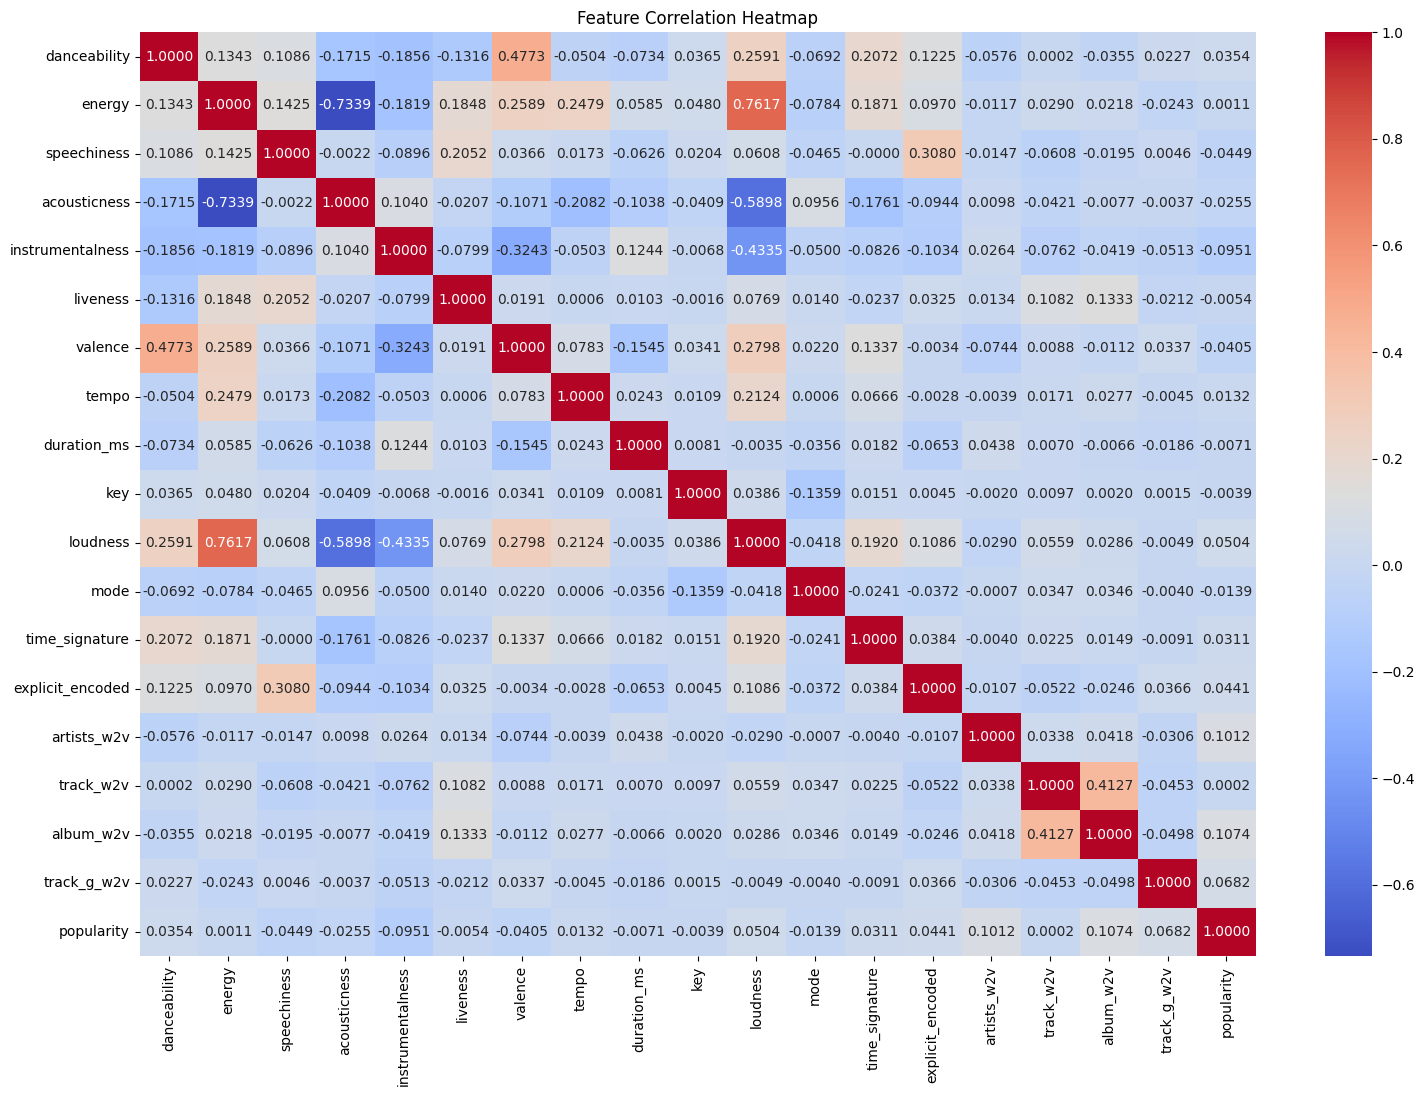

In [72]:
# Flatten embeddings
df["artists_w2v"] = df["artists_embedding"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)
df["track_w2v"] = df["track_embedding"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)
df["album_w2v"] = df["album_embedding"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)
df["track_g_w2v"] = df["track_g_embedding"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)

# Select numerical features for correlation
numerical_features = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness",
                      "liveness", "valence", "tempo", "duration_ms", "key", "loudness", "mode",
                      "time_signature", "explicit_encoded", "artists_w2v", "track_w2v", "album_w2v", "track_g_w2v"]

corr_matrix = df[numerical_features + ["popularity"]].corr()

# Plot heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [76]:
w2v_model.save("w2v_model.bin")

In [73]:
data = df.drop(columns=["speechiness","acousticness","instrumentalness","liveness","valence","duration_ms","mode","track_w2v","Unnamed: 0","artists_tokenized","album_tokenized","track_tokenized","track_g_tokenized","artists_embedding","track_embedding","album_embedding","track_g_embedding","track_id"])

In [74]:
data["explicit_encoded"] = df["explicit"].astype(int)
data.drop(columns="explicit")
data

,artists,album_name,track_name,popularity,explicit,danceability,energy,key,loudness,tempo,time_signature,track_genre,explicit_encoded,artists_w2v,album_w2v,track_g_w2v
0,Gen Hoshino,Comedy,Comedy,73,False,0.676,0.4610,1,-6.746,87.917,4,acoustic,0,0.000169,0.018051,-0.000065
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,False,0.420,0.1660,1,-17.235,77.489,4,acoustic,0,0.001546,0.093309,-0.000065
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,False,0.438,0.3590,0,-9.734,76.332,4,acoustic,0,0.005072,0.190371,-0.000065
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,False,0.266,0.0596,0,-18.515,181.740,3,acoustic,0,0.001757,0.008943,-0.000065
4,Chord Overstreet,Hold On,Hold On,82,False,0.618,0.4430,2,-9.681,119.949,4,acoustic,0,0.000262,0.360611,-0.000065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,False,0.172,0.2350,5,-16.393,125.995,5,world-music,0,0.001714,0.073860,0.001551
113996,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,False,0.174,0.1170,0,-18.318,85.239,4,world-music,0,0.001714,0.073860,0.001551
113997,Cesária Evora,Best Of,Miss Perfumado,22,False,0.629,0.3290,0,-10.895,132.378,4,world-music,0,0.002228,0.220851,0.001551
113998,Michael W. Smith,Change Your World,Friends,41,False,0.587,0.5060,7,-10.889,135.960,4,world-music,0,0.005044,0.228366,0.001551


In [75]:
data.to_csv("spotify_modded_3.csv", encoding='utf-8', index=False)

PermissionError: [Errno 13] Permission denied: 'spotify_modded_3.csv'

In [ ]:
feature_cols = ['danceability', 'energy',  
                'tempo', 
                'key', 'loudness', 'time_signature', 'explicit',
                'artists_w2v', 'album_w2v', 'track_g_w2v']

data = df[feature_cols]
data.skew()

danceability      -0.399497
energy            -0.597001
tempo              0.232295
key               -0.008500
loudness          -2.006542
time_signature    -4.098317
explicit           2.964731
artists_w2v       10.642942
album_w2v          1.150158
track_g_w2v        2.602908
dtype: float64

In [ ]:
data.duplicated().sum()

730

In [ ]:
data.isnull().sum()

danceability      0
energy            0
tempo             0
key               0
loudness          0
time_signature    0
explicit          0
artists_w2v       0
album_w2v         0
track_w2v         0
track_g_w2v       0
dtype: int64

In [ ]:
data.dtypes

danceability      float64
energy            float64
tempo             float64
key                 int64
loudness          float64
time_signature      int64
explicit             bool
artists_w2v       float32
album_w2v         float32
track_w2v         float32
track_g_w2v       float32
dtype: object

In [ ]:
df.dtypes

Unnamed: 0             int64
track_id              object
artists               object
album_name            object
track_name            object
popularity             int64
duration_ms            int64
explicit                bool
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature         int64
track_genre           object
artists_tokenized     object
track_tokenized       object
album_tokenized       object
track_g_tokenized     object
artists_embedding     object
track_embedding       object
album_embedding       object
track_g_embedding     object
explicit_encoded       int32
artists_w2v          float32
track_w2v            float32
album_w2v            float32
track_g_w2v          float32
dtype: object

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Select numerical features (excluding categorical ones)
feature_cols = ['danceability', 'energy',  
                'tempo', 
                'key', 'loudness', 'time_signature', 'explicit',
                'artists_w2v', 'album_w2v', 'track_w2v', 'track_g_w2v']
X = df[feature_cols]
y = df["popularity"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Model MAE: {mae}")

Final Model MAE: 10.540942636278196


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 10.540942636278196
Root Mean Squared Error (RMSE): 14.622529481732757
R² Score: 0.5667139805689663


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define a threshold (e.g., popularity > 50 is "popular", else "not popular")
threshold = 50
y_test_class = (y_test > threshold).astype(int)   # Actual classes
y_pred_class = (y_pred.flatten() > threshold).astype(int)   # Predicted classes

# Compute classification metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.82
Precision: 0.80
Recall: 0.32


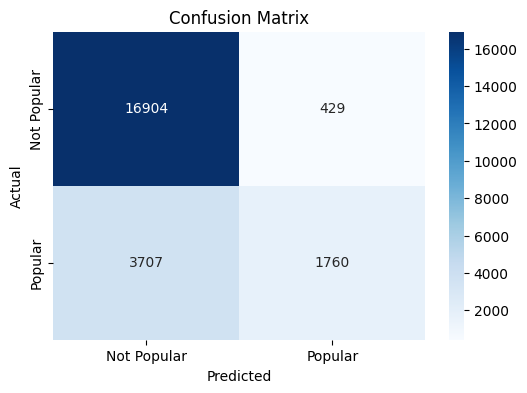

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Popular", "Popular"], yticklabels=["Not Popular", "Popular"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

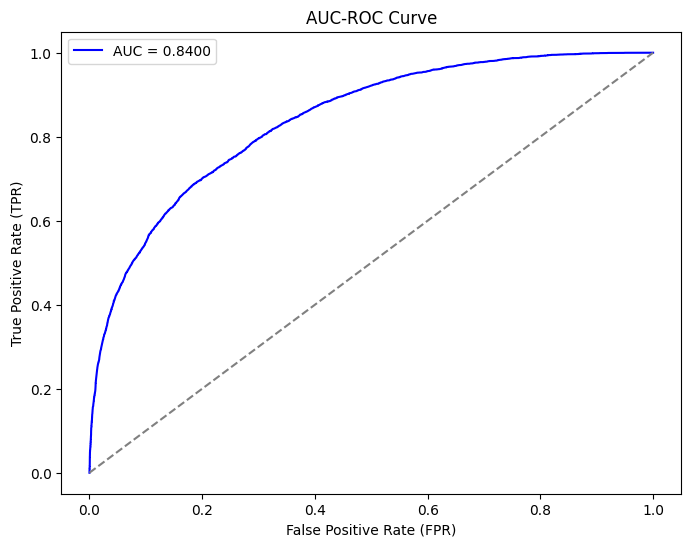

AUC Score: 0.8400


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred.flatten())  # Use predicted scores, not binary labels
auc_score = roc_auc_score(y_test_class, y_pred.flatten())

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal (random guess)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("AUC-ROC Curve")
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.4f}")


In [ ]:
gini = 2*auc_score - 1
gini

0.6800783828443351

In [ ]:
df.head(2)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,track_g_tokenized,artists_embedding,track_embedding,album_embedding,track_g_embedding,explicit_encoded,artists_w2v,track_w2v,album_w2v,track_g_w2v
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,...,[acoustic],"[-0.0012073899, 0.017586272, 0.0007013464, 0.0...","[-0.52287817, 0.26049772, -0.122430846, 0.4160...","[-0.52287817, 0.26049772, -0.122430846, 0.4160...","[-0.040711448, 0.0044788974, 0.0059315385, 0.0...",0,0.000169,0.021646,0.021646,0.00183
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,...,[acoustic],"[-0.008610599, -0.0024771714, 0.008165505, -0....","[-0.48934153, 1.5681643, -0.008578519, 2.28298...","[-0.62004304, 0.7796933, -0.36134377, 0.920240...","[-0.040711448, 0.0044788974, 0.0059315385, 0.0...",0,0.001546,0.131223,0.087846,0.00183


In [ ]:
import joblib
joblib.dump(model, "spotify_popularity_model_new.pkl")

['spotify_popularity_model_new.pkl']

In [ ]:
feat_cols = ['artists', 'album_name', 'track_name', 'track_genre',
                'danceability', 'energy',  
                'tempo', 
                'key', 'loudness', 'time_signature', 'explicit',
                'artists_w2v', 'album_w2v', 'track_w2v', 'track_g_w2v']
final_data = df[feat_cols]
final_data.dtypes

artists            object
album_name         object
track_name         object
track_genre        object
danceability      float64
energy            float64
tempo             float64
key                 int64
loudness          float64
time_signature      int64
explicit             bool
artists_w2v       float32
album_w2v         float32
track_w2v         float32
track_g_w2v       float32
dtype: object

In [ ]:
final_data.to_csv("final_spotify_modded.csv",encoding="utf-8",index=False)